# Varying all parameters together

This corresponds to part 1.3 in the report. Now that we know how our different variables influence the impact parameter, we will vary all of them
together to see the distribution of $b$ and $t_b$ in this case, which will be more consistent with the physical
reality. As the Monte-Carlo samples are random by definition, we generate 500 different sets that contain
different values of all the variables. We add a Cubic Spline interpolation inside the orbit integration for
more precision on the impact parameter, allowing us to determine the time of each merger more precisely. 

## Imports 

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from tqdm import tqdm
from scipy.interpolate import CubicSpline

## Simulation parameters

In [39]:
# Number of galaxies
N         = 2 

#Time parameters
t         = 0      # current time of the simulation, 13.6 Gyr

tEnd      = 8000*u.Myr  # time at which simulation ends
tEnd      = tEnd.si.value

dt        = 10*u.Myr  # timestep
dt        = dt.si.value

T=np.linspace(t, tEnd, int(tEnd / dt) +1) #list contaning all time values
T=np.array(T)


#Hernquist softening length
softening = 17*u.kpc 
softening = softening.si.value 

# Newton's Gravitational Constant
G         = 6.67430*10**(-11)*u.N*u.m**2*u.kg**(-2)   
G         = G.si.value


# Distance between Andromeda and Milky Way nowadays
r=765*u.kpc
r=r.si.value
dr=11*u.kpc
dr=dr.si.value

# Milky Way Mass
MW=0.9*10**12*u.Msun
MW=MW.si.value
dMW=0.4*10**12*u.Msun
dMW=dMW.si.value

# Andromeda mass
M31=2.3*10**12*u.Msun
M31=M31.si.value
dM31=1.0*10**12*u.Msun
dM31=dM31.si.value

# Andromeda radial velocity
vr=-109.3*u.km/u.s
vr=vr.si.value
dvr=4.4*u.km/u.s
dvr=dvr.si.value

# Andromeda transverse velocity
vt=57*u.km/u.s
vt=vt.si.value
dvt=35*u.km/u.s
dvt=dvt.si.value


### Cinematics functions :

In [40]:
def getAcc( pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    G is Newton's Gravitational constant
    softening is the softening length
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

### Calculating impact parameter and time function

In [41]:
def calculate_B_and_t(t,positions,velocities,masses, N_values) :

    blist=[]
    tlist=[]


    for j in tqdm (range (N_values)):
    

        mass = masses[:,j]
        pos = positions[:,:,j]
        vel = velocities[:,:,j]

        

        mass = np.reshape(mass, (2,1))
    

       # vel = vel-np.mean(mass * vel,0) / np.mean(mass)
        vel -= np.mean(mass * vel,0) / np.mean(mass)
        # calculate initial gravitational accelerations
        acc = getAcc( pos, mass, G, softening )

                        
        # number of timesteps
        Nt = int(np.ceil( (tEnd) /dt))

        # save energies, particle orbits for plotting trails
        pos_save = np.zeros((N,3,Nt+1))
        pos_save[:,:,0] = pos
        vel_save = np.zeros((N,3,Nt+1))
        vel_save[:,:,0] = vel         
        t_all = np.arange(Nt+1)*dt

        t = 0

        # Simulation Main Loop
        for i in range(Nt):
                        

            # (1/2) kick
            vel += acc * dt /2.0

            acc_old = acc

            # drift
            pos += vel * dt


            # update accelerations
            acc = getAcc( pos, mass, G, softening )

            # (1/2) kick
            vel += acc * dt/2.0

            # update time
            t += dt
                  
            # save energies, positions for plotting trail
            pos_save[:,:,i+1] = pos
            vel_save[:,:,i+1] = vel

                    

        xx = pos_save[:,0,:]
        yy = pos_save[:,1,:]

        x1=pos_save[0,0,:]
        x2=pos_save[1,0,:]
        y1=pos_save[0,1,:]
        y2=pos_save[1,1,:]

        #Calculating impact parameter

        r=np.sqrt((x2-x1)**2+(y2-y1)**2)
        b=min(r)
        t=np.argmin(r)*dt


        #Interpolation for more precision

        
        f = CubicSpline(T,r,bc_type='natural')
        timesteps=1000
        T_new=np.linspace(t-dt,t+dt,timesteps)
        
        r_new=f(T_new)
        b=min(r_new)
        t= t - dt + np.argmin(r_new)*(2*dt / timesteps)

        #Adding b and t to their list
        
        blist.append(b)
        tlist.append(t)
    
    barray=np.array(blist)
    tarray=np.array(tlist)
    return barray, tarray


### Initial conditions variation

In [42]:
N_values = 1000

x1= np.zeros(N_values)      
x2= np.random.normal(r,dr,N_values)
y1= np.zeros(N_values)       
y2= np.zeros(N_values)       
z1= np.zeros(N_values)       
z2= np.zeros(N_values)       

vx1= np.zeros(N_values)   
vx2= np.random.normal(vr,dvr,N_values)
vy1= np.zeros(N_values)     
vy2= np.abs(np.random.normal(vt,dvt,N_values))     
vz1= np.zeros(N_values)    
vz2= np.zeros(N_values)     

M1= np.abs(np.random.normal(MW,dMW,N_values))
M2= np.abs(np.random.normal(M31,dM31,N_values))   

#Vectors containing the values of initial conditions

positions = np.array([[x1,y1,z1], [x2,y2,z2]])
velocities =  np.array([[vx1,vy1,vz1], [vx2,vy2,vz2]])
masses = np.array([M1,M2])

### Calculations

In [43]:
var_B, var_t=calculate_B_and_t(t,positions,velocities,masses, N_values)

100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


### Unit fix

In [44]:
#fixing units

a=1*u.kpc
a=a.si.value
m=1**10**12*u.Msun
m=m.si.value
p=1*u.Myr
p=p.si.value

x2=x2/a
vx2=vx2/1000
vy2=vy2/1000
M1=M1/m
M2=M2/m

var_B=var_B/a

var_t=var_t/p
M1 =M1/1e12
M2=M2/1e12


### Plots

<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:50: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:50: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_12084\1847680497.py:39: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{MW} (10^{12} M_{\odot}$)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_12084\1847680497.py:50: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{M31} (10^{12} M_{\odot}$)')


mean r= 765.3444644921126
median r 765.4123188276292
standard deviation r= 11.398540525537488
11.447028097599855
11.891805061823447
mean vr= -109.23894243137025
median vr= -109.30013950517136
standard deviation vr= 4.177252908079924
3.990916218861713
4.197193142437328
mean vt= 56.95248695678126
median vt= 55.07910291710158
standard deviation vt= 31.00459772776831
29.25905217273936
34.68606852133429
mean mw= 0.9053744562115028
median mw= 0.9073256614999441
standard deviation mw= 0.40063113114078774
0.43854152787235406
0.3942543386890558
mean m31= 2.311374373553659
median m31= 2.3009914756896057
standard deviation m31= 0.9824300982094106
1.0531993434300781
0.9999849272012482


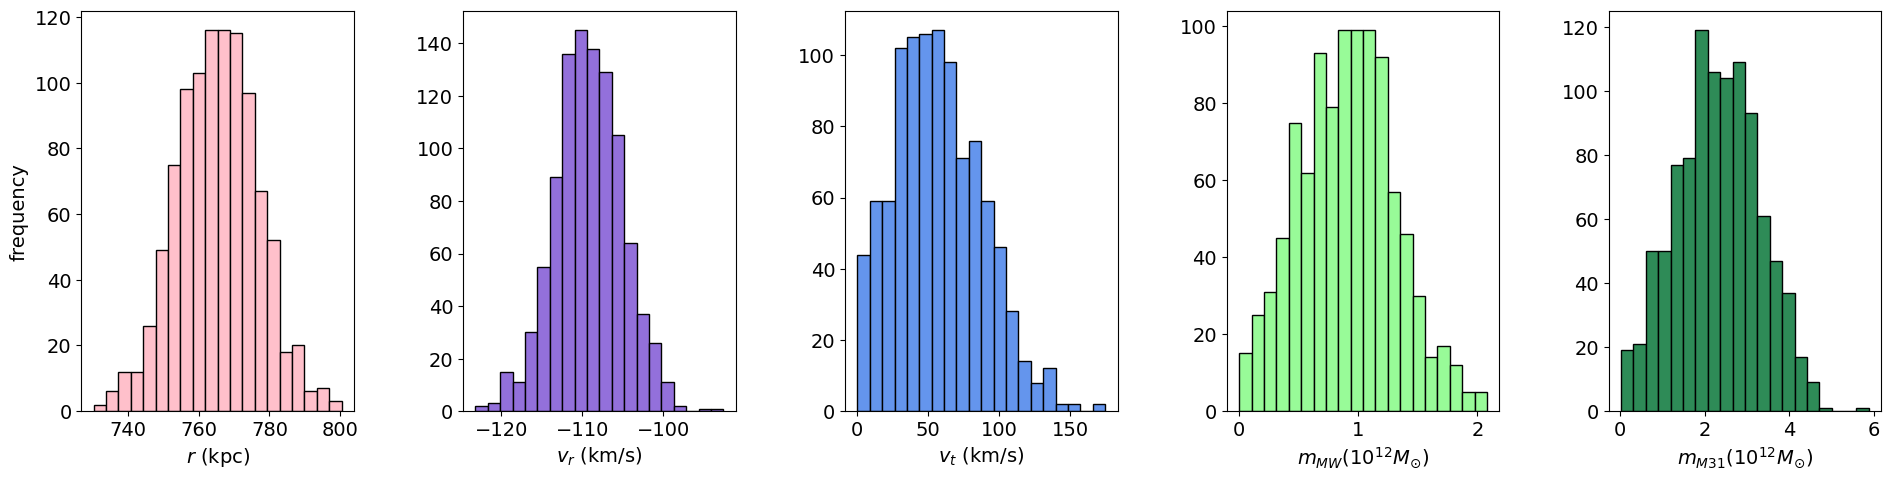

In [45]:
# Initial conditions variations

plt.figure(figsize = (10, 5)) 

plt.subplot(1,5,1)
plt.hist(x2,color='pink',ec='black',bins=20)
plt.xlabel('$r$ (kpc)')
plt.ylabel('frequency')

print('mean r=',np.mean(x2))
print('median r',np.median(x2))
print('standard deviation r=',np.std(x2))
print(np.median(x2) - np.percentile(x2, 15.8))
print(np.percentile(x2, 84.5) - np.median(x2))


plt.subplot(1,5,2)
plt.hist(vx2,color='mediumpurple',ec='black',bins=20)
plt.xlabel('$v_r$ (km/s)')

print('mean vr=',np.mean(vx2))
print('median vr=',np.median(vx2))
print('standard deviation vr=',np.std(vx2))
print(np.median(vx2) - np.percentile(vx2, 15.8))
print(np.percentile(vx2, 84.5) - np.median(vx2))

plt.subplot(1,5,3)
plt.hist(vy2,color='cornflowerblue',ec='black',bins=20)
plt.xlabel('$v_t$ (km/s)')

print('mean vt=',np.mean(vy2))
print('median vt=',np.median(vy2))
print('standard deviation vt=',np.std(vy2))
print(np.median(vy2) - np.percentile(vy2, 15.8))
print(np.percentile(vy2, 84.5) - np.median(vy2))

plt.subplot(1,5,4)
plt.hist(M1, color='palegreen',ec='black',bins=20)
plt.xlabel('$m_{MW} (10^{12} M_{\odot}$)')

print('mean mw=',np.mean(M1))
print('median mw=',np.median(M1))
print('standard deviation mw=',np.std(M1))
print(np.median(M1) - np.percentile(M1, 15.8))
print(np.percentile(M1, 84.5) - np.median(M1))


plt.subplot(1,5,5)
plt.hist(M2,color='seagreen',ec='black',bins=20)
plt.xlabel('$m_{M31} (10^{12} M_{\odot}$)')

print('mean m31=',np.mean(M2))
print('median m31=',np.median(M2))
print('standard deviation m31=',np.std(M2))
print(np.median(M2) - np.percentile(M2, 15.8))
print(np.percentile(M2, 84.5) - np.median(M2))


plt.gcf().subplots_adjust(left = 0.2, bottom = 0.1, right = 2, top = 0.9, wspace = 0.4, hspace = 0.3)

<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_12084\1050037636.py:20: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$m_{MW} (M_{\odot}$)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_12084\1050037636.py:25: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$m_{M31} (M_{\odot}$)')


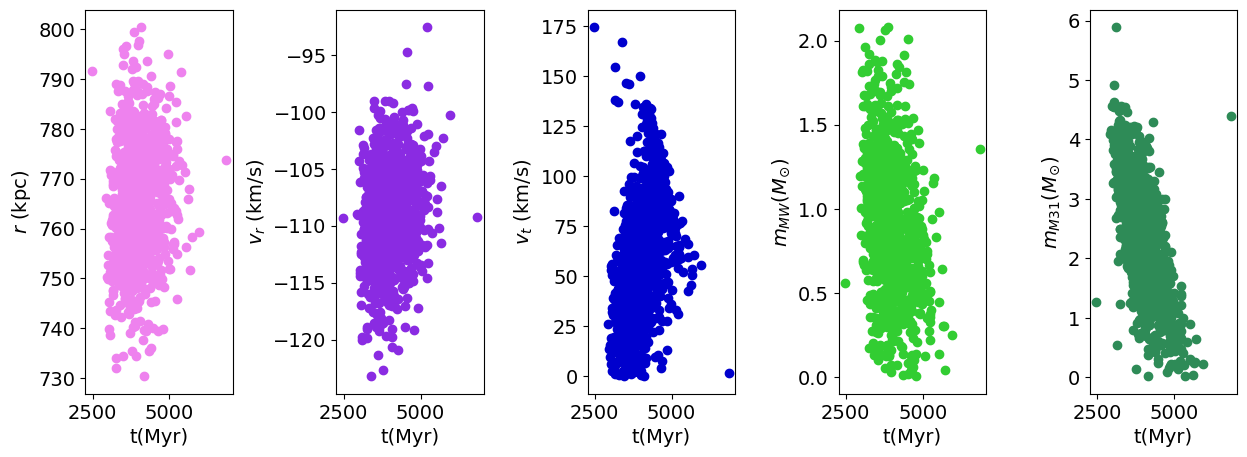

In [46]:
# Variation of those conditions with time

plt.subplot(1,5,1)
plt.scatter(var_t,x2,color='violet')
plt.ylabel('$r$ (kpc)')
plt.xlabel('t(Myr)')

plt.subplot(1,5,2)
plt.scatter(var_t,vx2,color='blueviolet')
plt.ylabel('$v_r$ (km/s)')
plt.xlabel('t(Myr)')

plt.subplot(1,5,3)
plt.scatter(var_t,vy2,color='mediumblue')
plt.ylabel('$v_t$ (km/s)')
plt.xlabel('t(Myr)')

plt.subplot(1,5,4)
plt.scatter(var_t,M1, color='limegreen')
plt.ylabel('$m_{MW} (M_{\odot}$)')
plt.xlabel('t(Myr)')

plt.subplot(1,5,5)
plt.scatter(var_t,M2,color='seagreen')
plt.ylabel('$m_{M31} (M_{\odot}$)')
plt.xlabel('t(Myr)')

plt.gcf().subplots_adjust(left = 0.2, bottom = 0.1, right = 2, top = 0.9, wspace = 0.7, hspace = 0.5)


mean= 106.82442139024717
median= 71.34458336204477
standard deviation= 105.37481807658523
52.24234518945511
144.08008261727028
2.8262930315716734


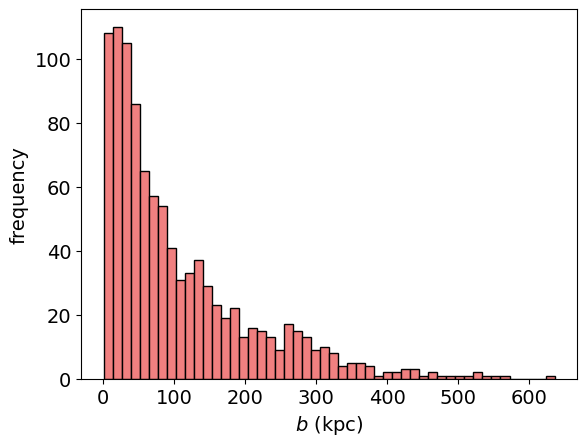

In [47]:
# Impact parameter distribution

plt.rcParams.update({'font.size':14})

plt.hist(var_B,color='lightcoral',ec='black',bins=50)
plt.ylabel('frequency')
plt.xlabel('$b$ (kpc)')
print('mean=',np.mean(var_B))
print('median=',np.median(var_B))
print('standard deviation=',np.std(var_B))
print(np.median(var_B) - np.percentile(var_B, 15.8))
print(np.percentile(var_B, 84.5) - np.median(var_B))
print(np.percentile(var_B,1))

mean= 3983.7311600000003
median= 3917.11
standard deviation= 535.3032724012196
446.45776000000023
645.3829999999994


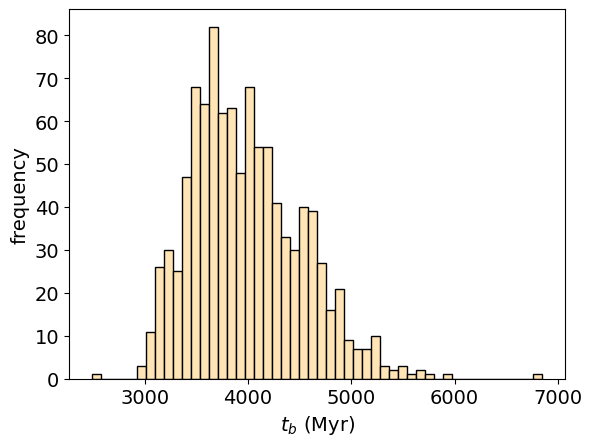

In [48]:
# Time of impact parameter distribution
plt.rcParams.update({'font.size':14})

plt.hist(var_t,color='moccasin', ec='black', bins=50)

plt.ylabel('frequency')
plt.xlabel('$t_b$ (Myr)')

print('mean=',np.mean(var_t))
print('median=',np.median(var_t))
print('standard deviation=',np.std(var_t))
print(np.median(var_t) - np.percentile(var_t, 15.8))
print(np.percentile(var_t, 84.5) - np.median(var_t))



### Without interpolation

In [49]:
N_values = 1000

x1= np.zeros(N_values)      
x2= np.random.normal(r,dr,N_values)
y1= np.zeros(N_values)       
y2= np.zeros(N_values)       
z1= np.zeros(N_values)       
z2= np.zeros(N_values)       

vx1= np.zeros(N_values)   
vx2= np.random.normal(vr,dvr,N_values)
vy1= np.zeros(N_values)     
vy2= np.abs(np.random.normal(vt,dvt,N_values))     
vz1= np.zeros(N_values)    
vz2= np.zeros(N_values)     

M1= np.abs(np.random.normal(MW,dMW,N_values))
M2= np.abs(np.random.normal(M31,dM31,N_values))   

#Vectors containing the values of initial conditions

positions = np.array([[x1,y1,z1], [x2,y2,z2]])
velocities =  np.array([[vx1,vy1,vz1], [vx2,vy2,vz2]])
masses = np.array([M1,M2])

In [50]:
def calculate_B_and_t_without_interp(t,positions,velocities,masses, N_values) :

    blist=[]
    tlist=[]


    for j in tqdm (range (N_values)):
    

        mass = masses[:,j]
        pos = positions[:,:,j]
        vel = velocities[:,:,j]

    

        mass = np.reshape(mass, (2,1))

       # vel = vel-np.mean(mass * vel,0) / np.mean(mass)
        vel -= np.mean(mass * vel,0) / np.mean(mass)
        # calculate initial gravitational accelerations
        acc = getAcc( pos, mass, G, softening )

                        
        # number of timesteps
        Nt = int(np.ceil( (tEnd) /dt))

        # save energies, particle orbits for plotting trails
        pos_save = np.zeros((N,3,Nt+1))
        pos_save[:,:,0] = pos
        vel_save = np.zeros((N,3,Nt+1))
        vel_save[:,:,0] = vel         
        t_all = np.arange(Nt+1)*dt

        t = 0

        # Simulation Main Loop
        for i in range(Nt):
            
            # (1/2) kick
            vel += acc * dt /2.0

            acc_old = acc

            # drift
            pos += vel * dt


            # update accelerations
            acc = getAcc( pos, mass, G, softening )

            # (1/2) kick
            vel += acc * dt/2.0

            # update time
            t += dt
                  
            # save energies, positions for plotting trail
            pos_save[:,:,i+1] = pos
            vel_save[:,:,i+1] = vel

                    

        xx = pos_save[:,0,:]
        yy = pos_save[:,1,:]

        x1=pos_save[0,0,:]
        x2=pos_save[1,0,:]
        y1=pos_save[0,1,:]
        y2=pos_save[1,1,:]

        #Calculating impact parameter

        r=np.sqrt((x2-x1)**2+(y2-y1)**2)
        b=min(r)
        t=np.argmin(r)*dt


        #Adding b and t to their list
        
        blist.append(b)
        tlist.append(t)
    
    barray=np.array(blist)
    tarray=np.array(tlist)
    return barray, tarray

In [51]:
var_B, var_t=calculate_B_and_t_without_interp(t,positions,velocities,masses, N_values)

100%|██████████| 1000/1000 [01:12<00:00, 13.74it/s]


In [52]:
#fixing units

a=1*u.kpc
a=a.si.value
m=1**10**12*u.Msun
m=m.si.value
p=1*u.Myr
p=p.si.value

x2=x2/a
vx2=vx2/1000
vy2=vy2/1000
M1=M1/m
M2=M2/m

var_B=var_B/a

var_t=var_t/p



mean= 115.39986636301664
median= 82.19716776222981
standard deviation= 108.4811582645012
64.08681009208512
142.65119312448667
2.8870404929514493


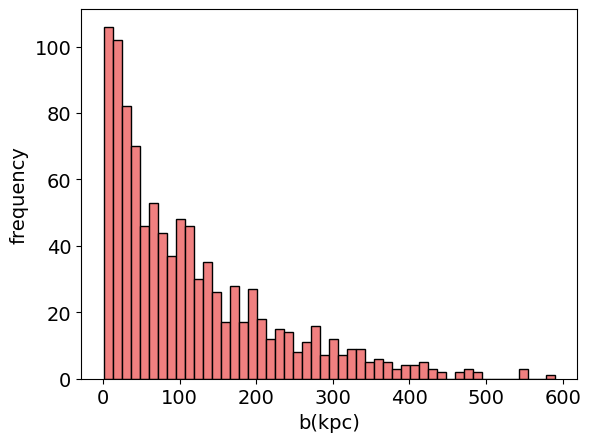

In [53]:
# Impact parameter distribution

plt.hist(var_B,color='lightcoral',ec='black',bins=50)
plt.ylabel('frequency')
plt.xlabel('b(kpc)')
print('mean=',np.mean(var_B))
print('median=',np.median(var_B))
print('standard deviation=',np.std(var_B))
print(np.median(var_B) - np.percentile(var_B, 15.8))
print(np.percentile(var_B, 84.5) - np.median(var_B))
print(np.percentile(var_B,1))


mean= 4010.19
median= 3965.0
standard deviation= 536.37455560457
515.0
595.0


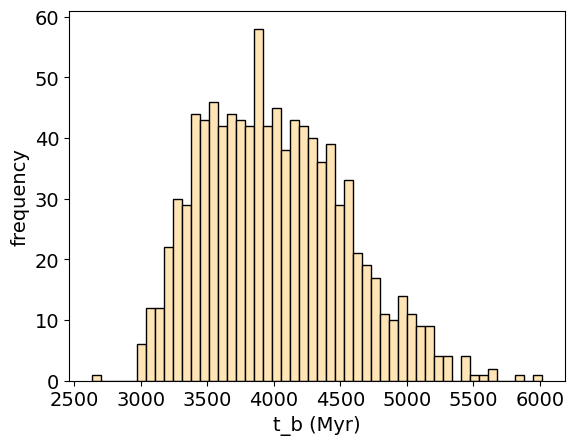

In [54]:
# Time of impact parameter distribution

plt.hist(var_t,color='moccasin', ec='black', bins=50)

plt.ylabel('frequency')
plt.xlabel('t_b (Myr)')

print('mean=',np.mean(var_t))
print('median=',np.median(var_t))
print('standard deviation=',np.std(var_t))
print(np.median(var_t) - np.percentile(var_t, 15.8))
print(np.percentile(var_t, 84.5) - np.median(var_t))
